In [1]:
import torch
from torch import optim, nn
import numpy as np

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

from UNet import ssim_loss
from models.vqvae import VQVAE

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

torch.Size([5, 386, 3, 64, 64])

torch.Size([4, 3, 72, 72])


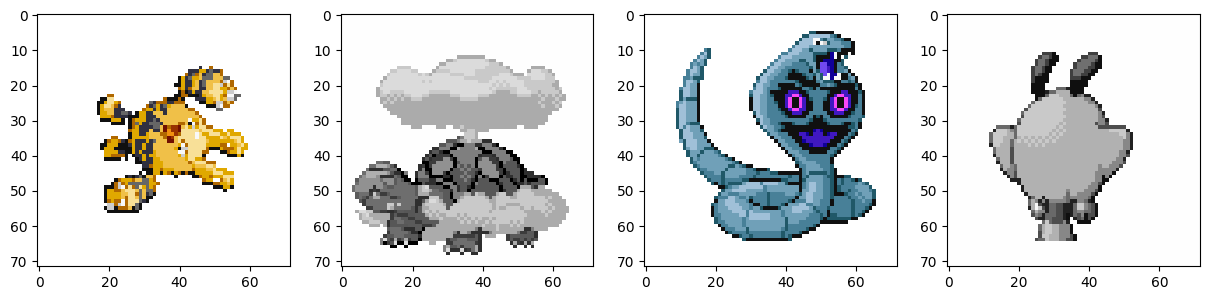

In [2]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    v2.RandomApply([v2.RandomAffine(0, (0, 0), (0.8, 1.4), 0, fill=1.0)], .2),
    v2.RandomApply([v2.RandomRotation(360, fill=1.0)], .2),
    #Sobel(),
])
col_transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], .3),
    v2.RandomApply([v2.RandomChannelPermutation()], .3),
    v2.RandomGrayscale(p = .3),
])

bs = 4
source = torch.randint(0, 5, (bs,))
batch = torch.randperm(385)[:bs]
x0 = pimages[source, batch]
x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
print(x0.shape)

fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

  0%|          | 0/50000 [00:00<?, ?it/s]

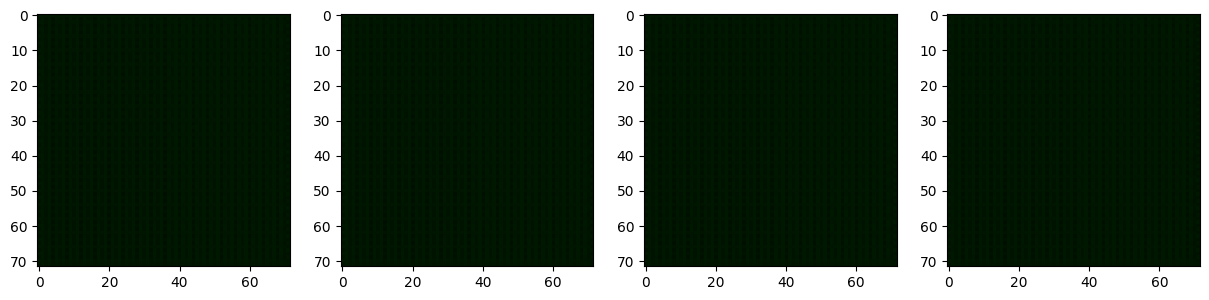

  2%|▏         | 994/50000 [00:20<16:41, 48.94it/s]

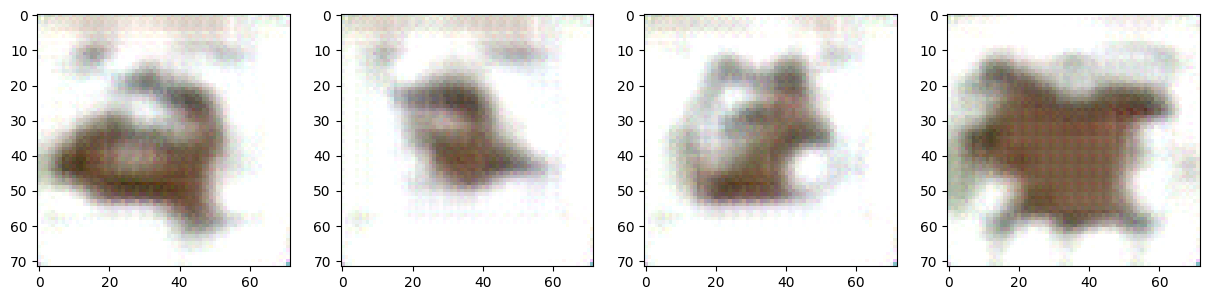

  4%|▍         | 1995/50000 [00:41<16:18, 49.06it/s]

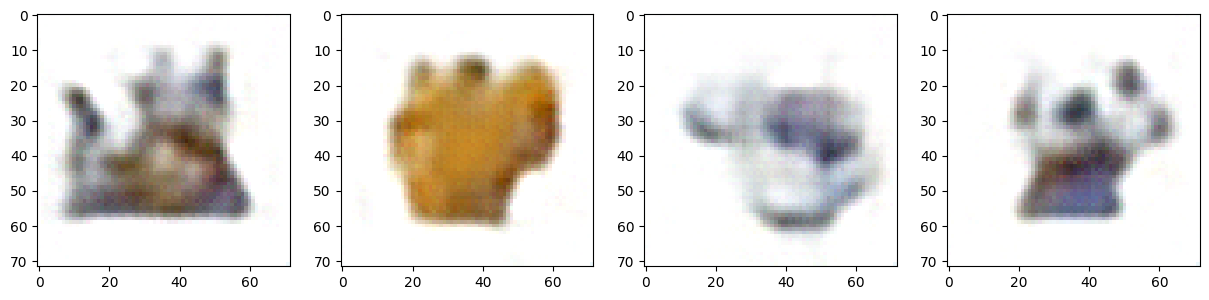

  6%|▌         | 2996/50000 [01:01<15:54, 49.24it/s]

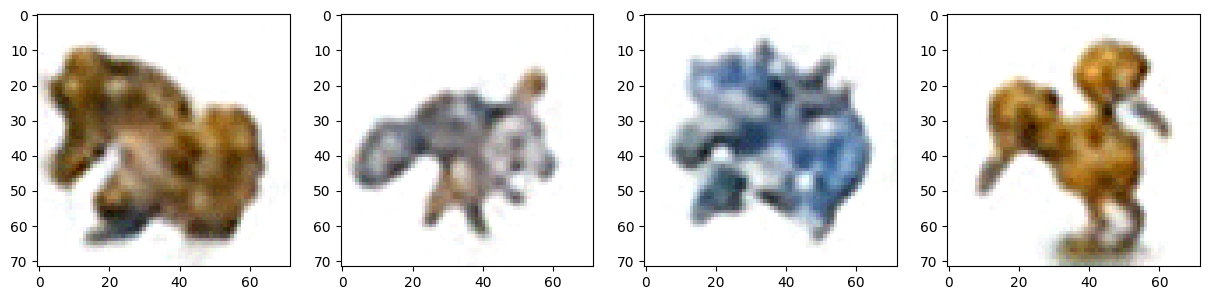

  8%|▊         | 3997/50000 [01:22<15:39, 48.99it/s]

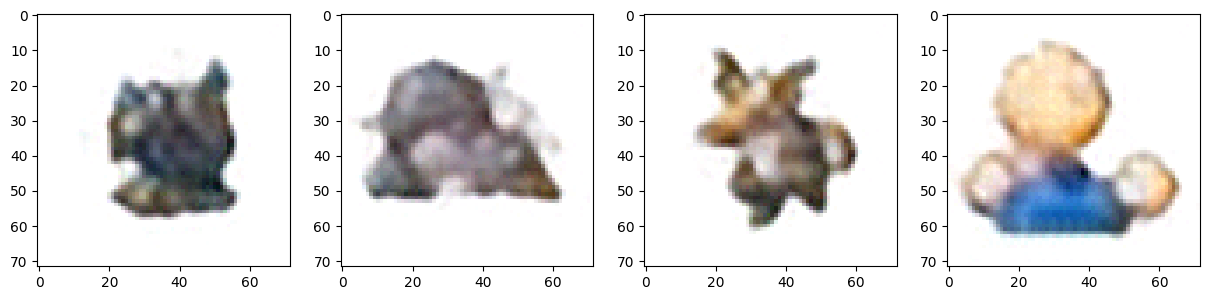

 10%|▉         | 4998/50000 [01:43<14:54, 50.32it/s]

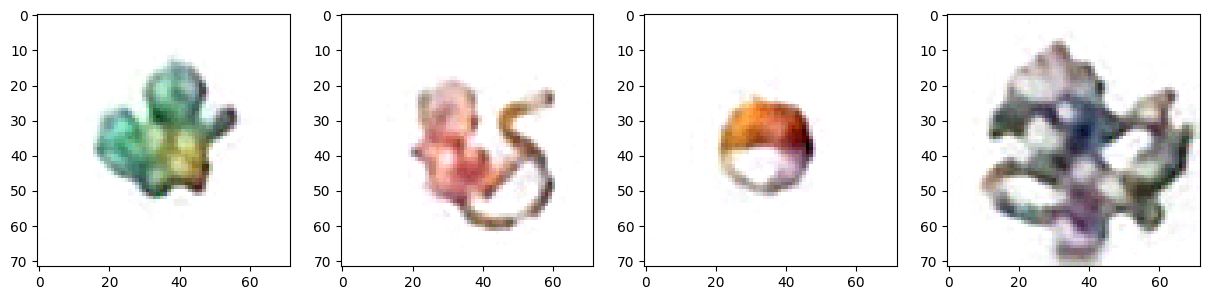

 12%|█▏        | 5999/50000 [02:03<14:59, 48.92it/s]

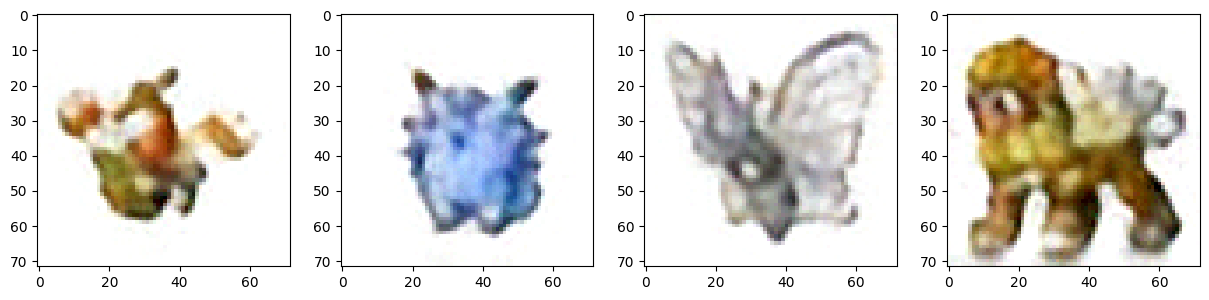

 14%|█▍        | 7000/50000 [02:23<14:47, 48.47it/s]

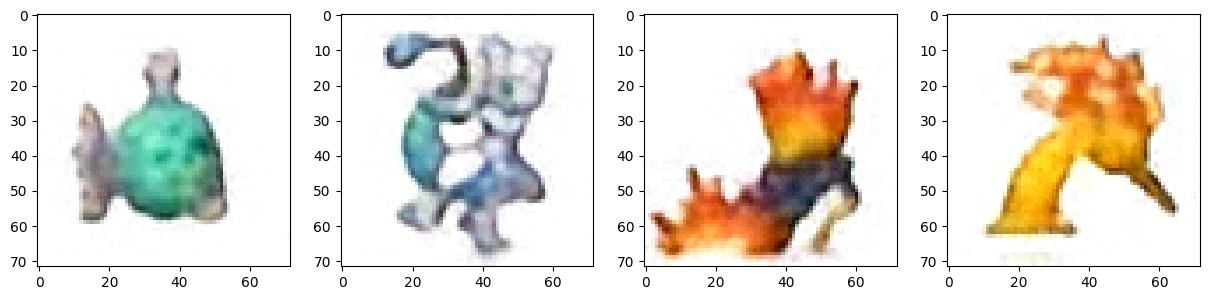

 16%|█▌        | 7994/50000 [02:43<14:11, 49.36it/s]

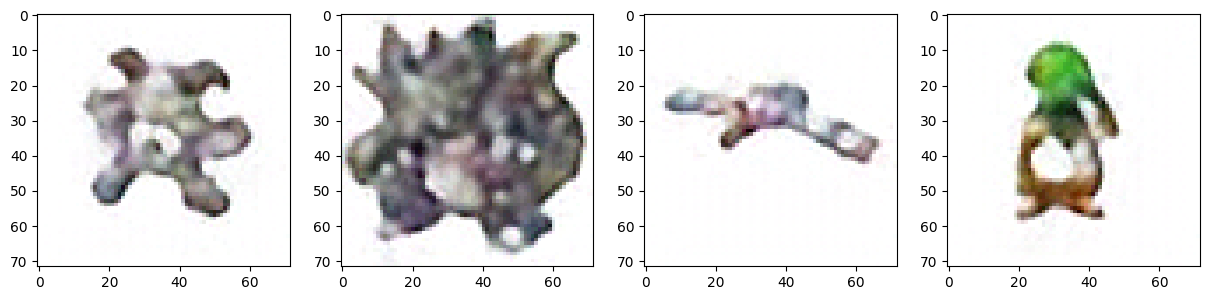

 18%|█▊        | 8995/50000 [03:03<16:21, 41.78it/s]

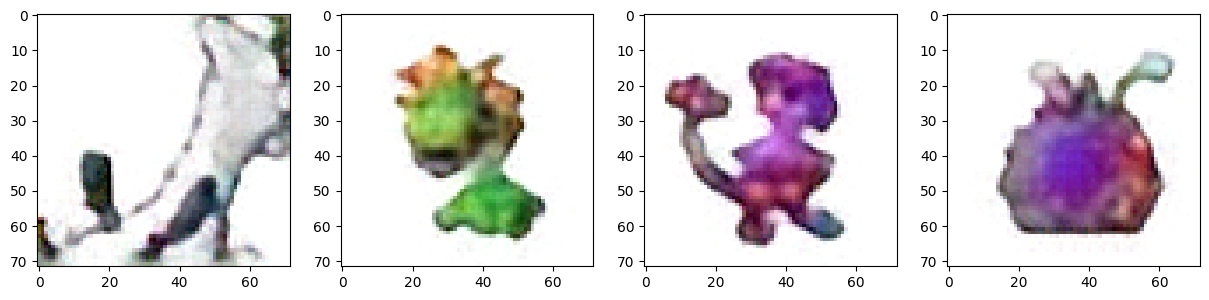

 20%|█▉        | 9996/50000 [03:23<13:42, 48.64it/s]

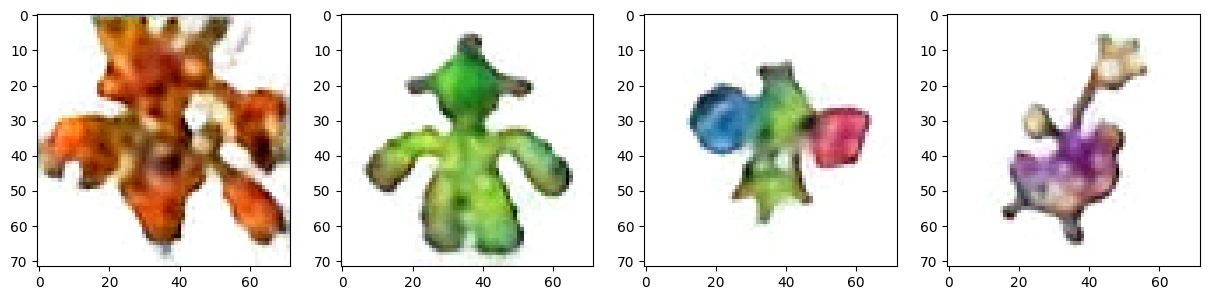

 22%|██▏       | 10997/50000 [03:43<12:26, 52.26it/s]

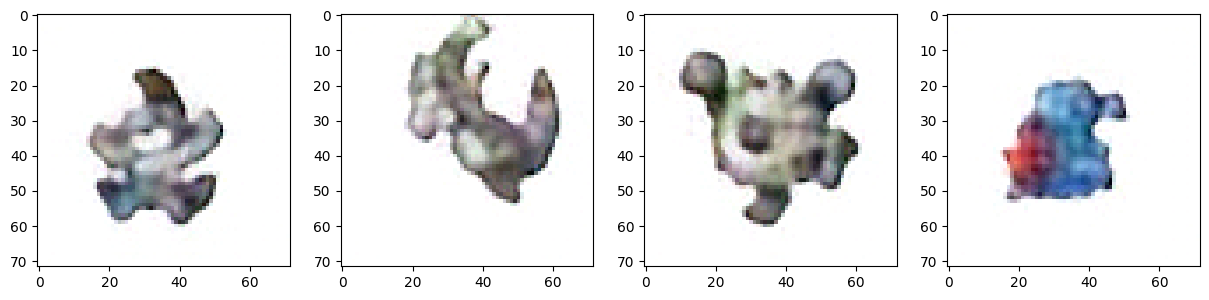

 24%|██▍       | 11998/50000 [04:04<13:36, 46.55it/s]

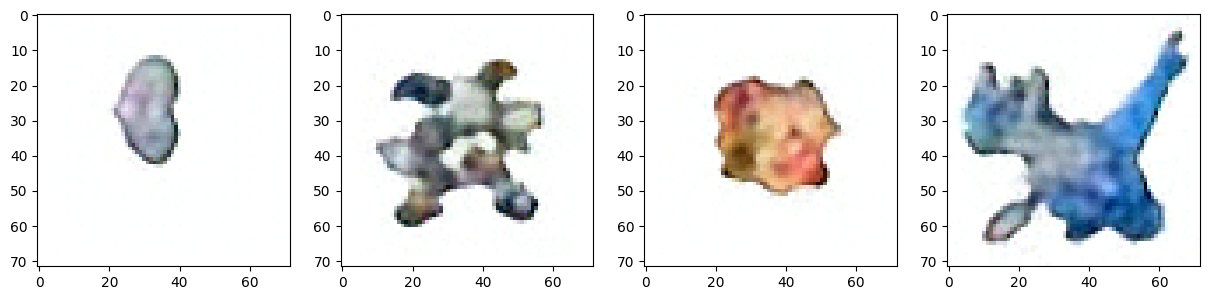

 26%|██▌       | 12999/50000 [04:24<12:16, 50.26it/s]

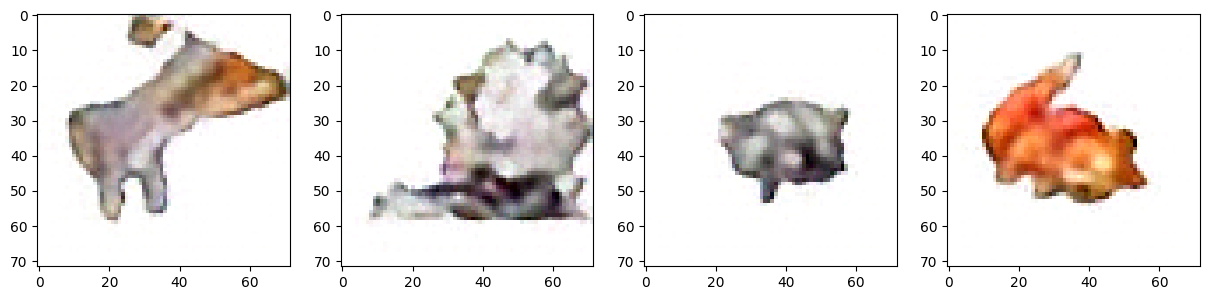

 28%|██▊       | 14000/50000 [04:44<11:44, 51.08it/s]

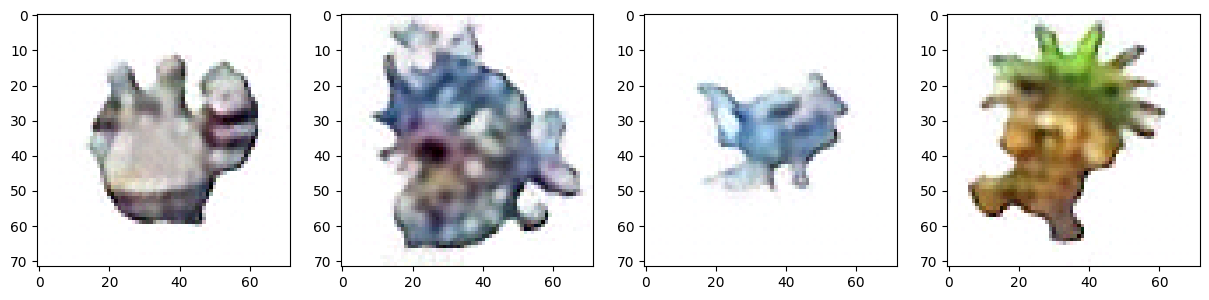

 30%|██▉       | 14994/50000 [05:04<11:13, 51.97it/s]

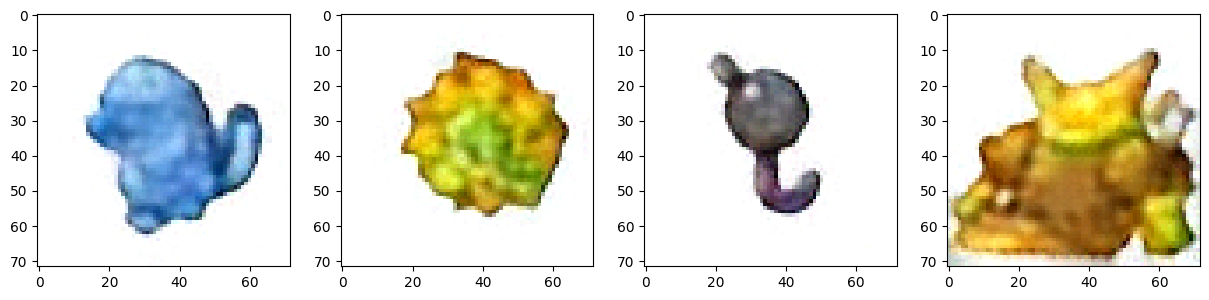

 32%|███▏      | 15995/50000 [05:25<11:51, 47.77it/s]

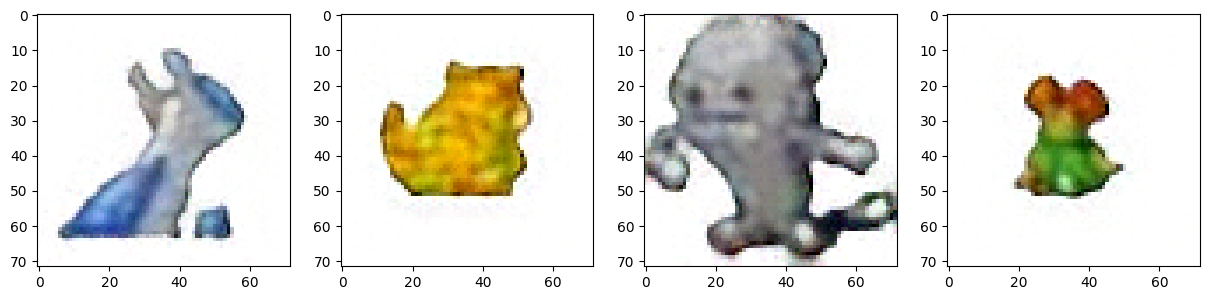

 34%|███▍      | 16996/50000 [05:45<10:19, 53.30it/s]

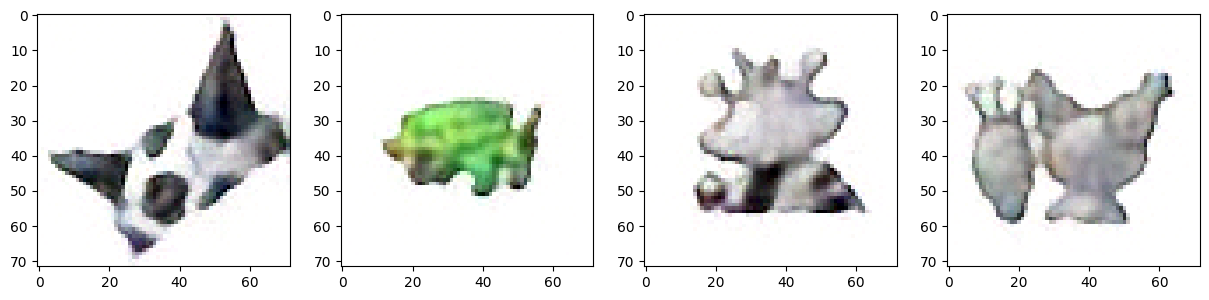

 36%|███▌      | 17997/50000 [06:05<09:58, 53.43it/s]

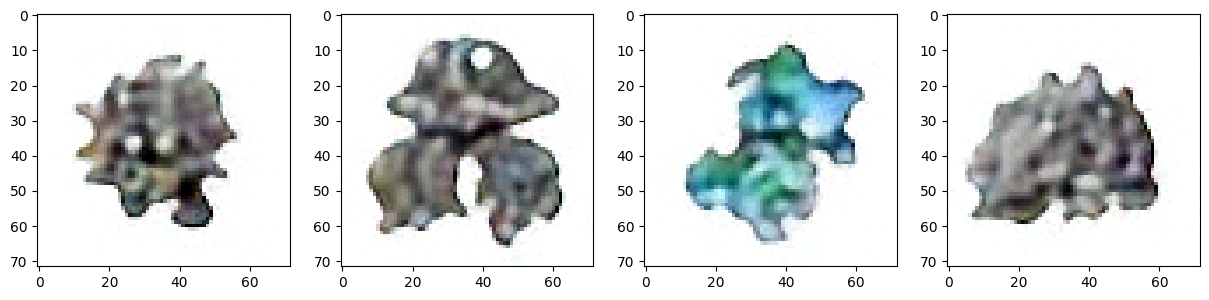

 38%|███▊      | 18998/50000 [06:26<11:04, 46.68it/s]

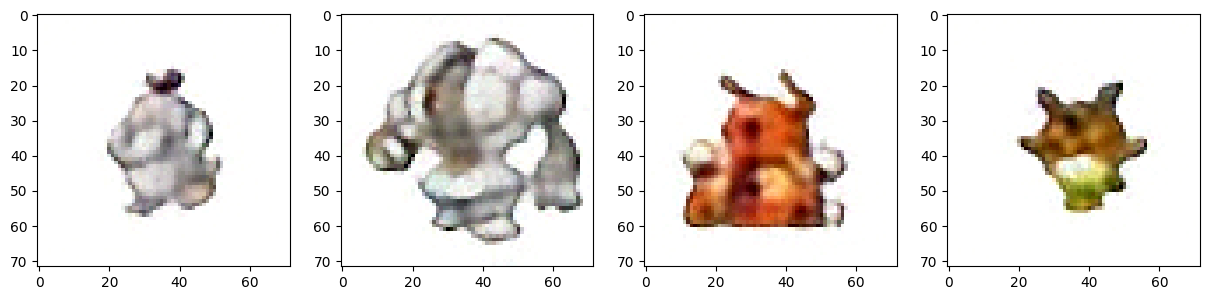

 40%|███▉      | 19999/50000 [06:46<09:04, 55.12it/s]

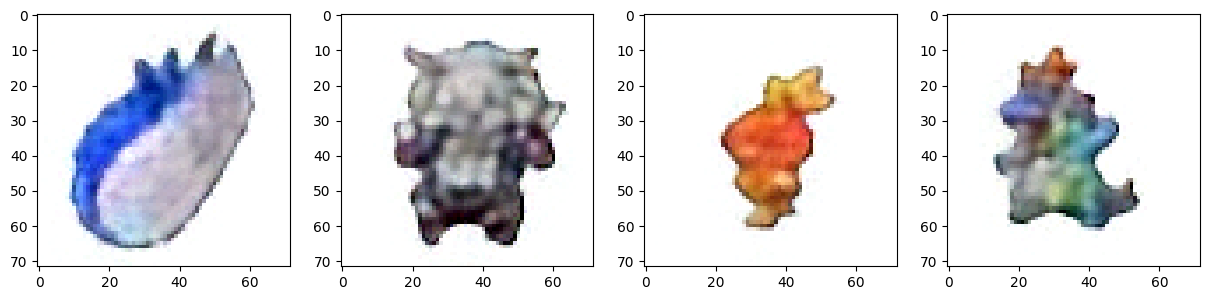

 42%|████▏     | 21000/50000 [07:06<09:57, 48.54it/s]

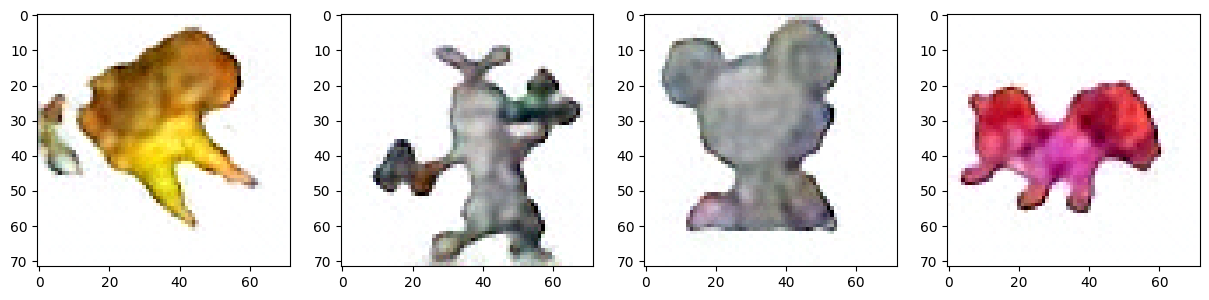

 44%|████▍     | 21994/50000 [07:26<08:15, 56.51it/s]

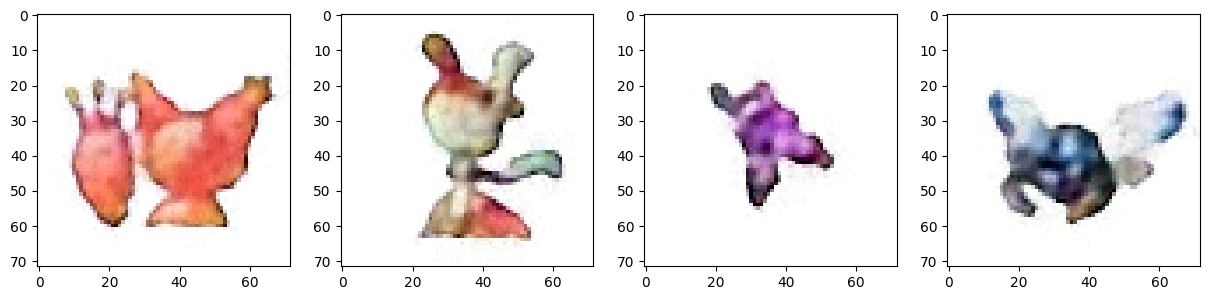

 46%|████▌     | 22995/50000 [07:45<08:20, 54.01it/s]

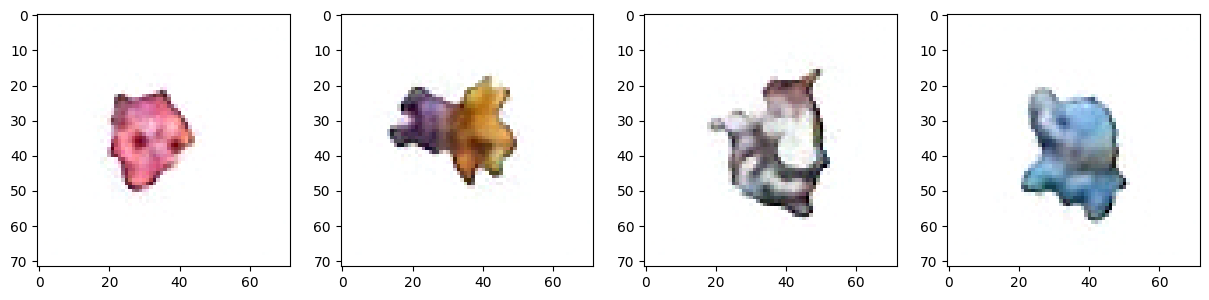

 48%|████▊     | 23996/50000 [08:05<07:46, 55.70it/s]

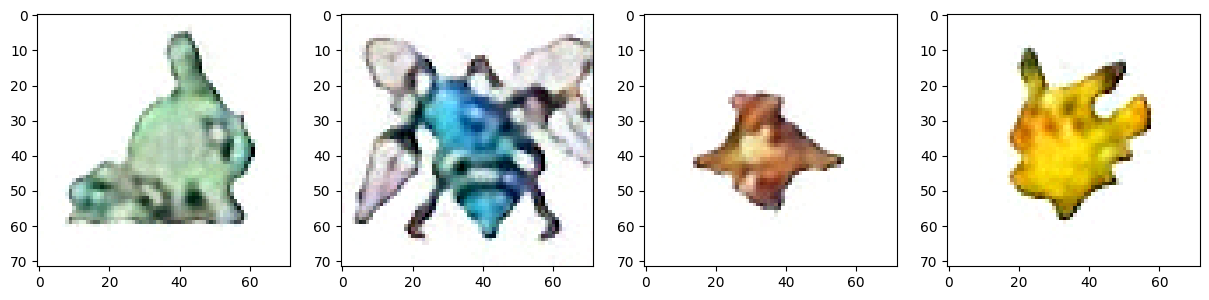

 50%|████▉     | 24997/50000 [08:25<08:09, 51.09it/s]

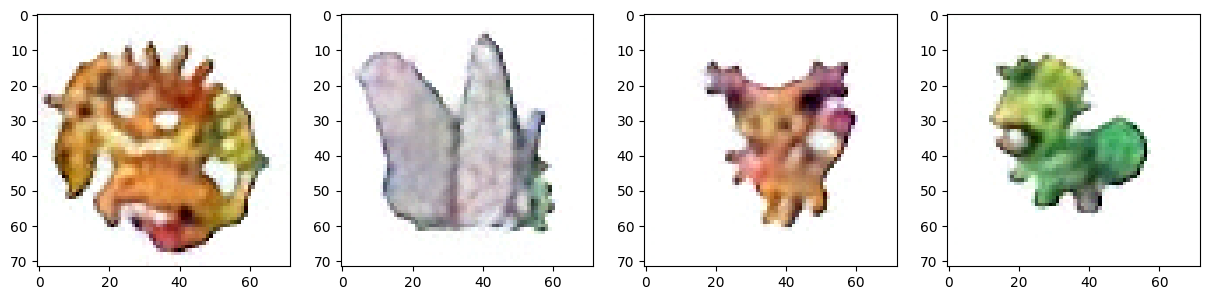

 52%|█████▏    | 25998/50000 [08:45<07:42, 51.89it/s]

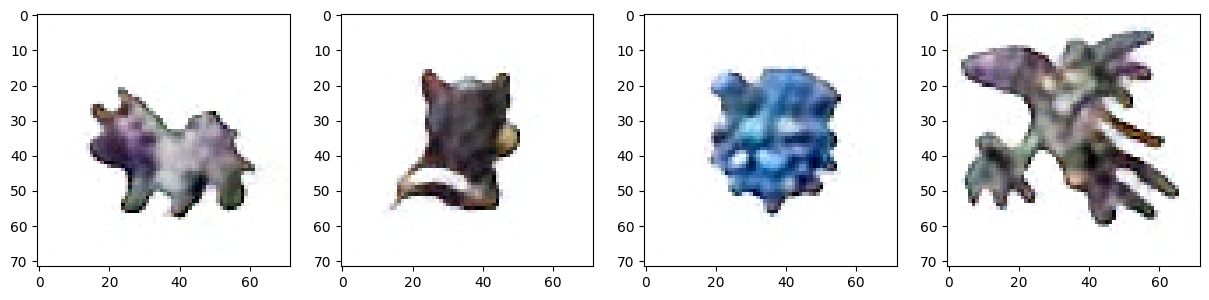

 54%|█████▍    | 26999/50000 [09:05<07:43, 49.57it/s]

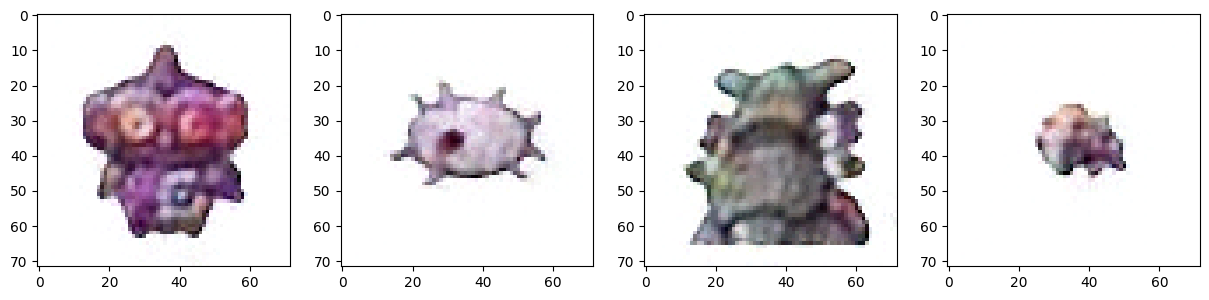

 56%|█████▌    | 28000/50000 [09:25<07:39, 47.85it/s]

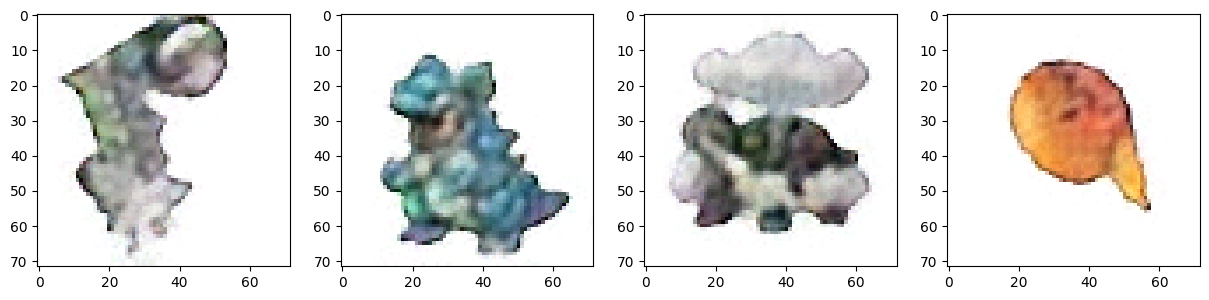

 58%|█████▊    | 28994/50000 [09:45<07:15, 48.21it/s]

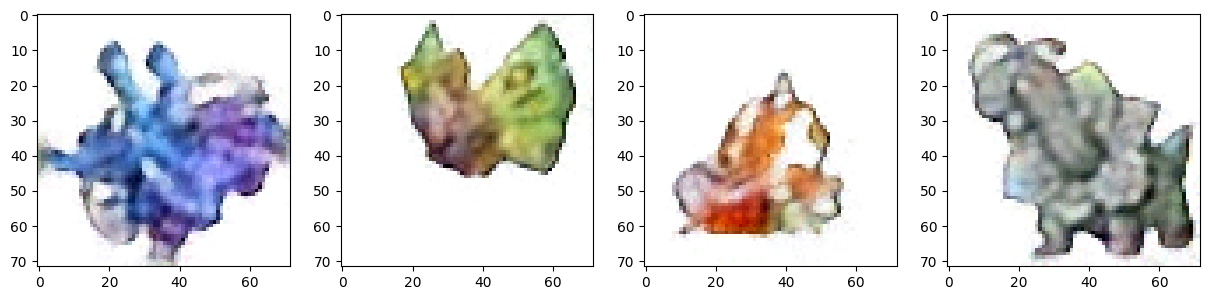

 60%|█████▉    | 29995/50000 [10:05<06:45, 49.37it/s]

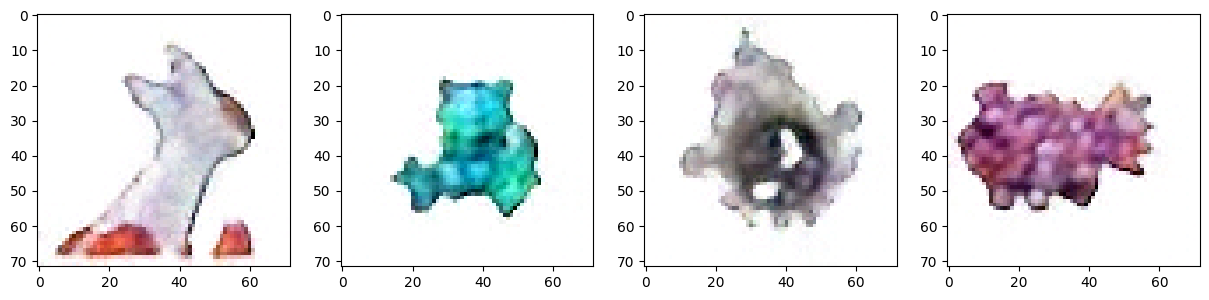

 62%|██████▏   | 30996/50000 [10:25<06:49, 46.43it/s]

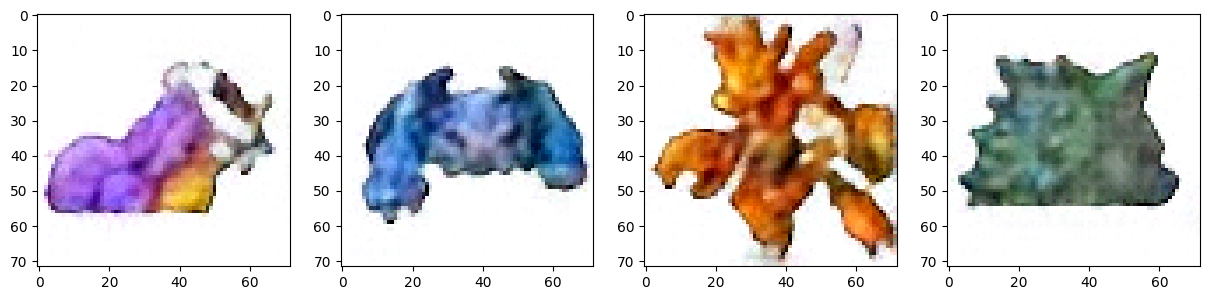

 64%|██████▍   | 31997/50000 [10:46<05:46, 51.91it/s]

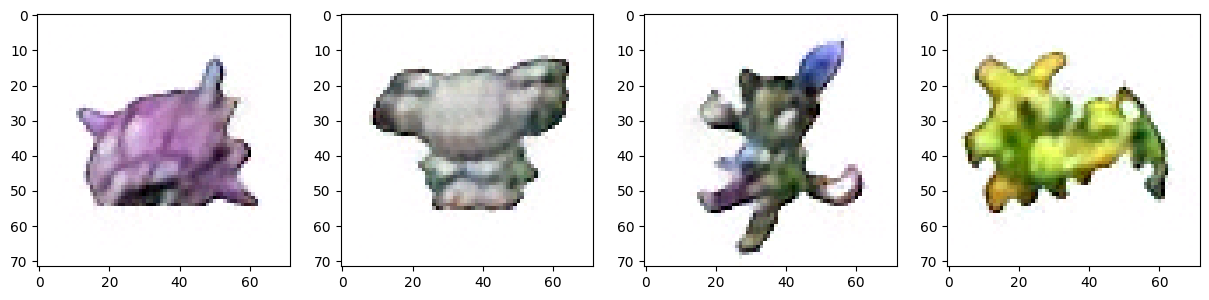

 66%|██████▌   | 32998/50000 [11:06<05:35, 50.69it/s]

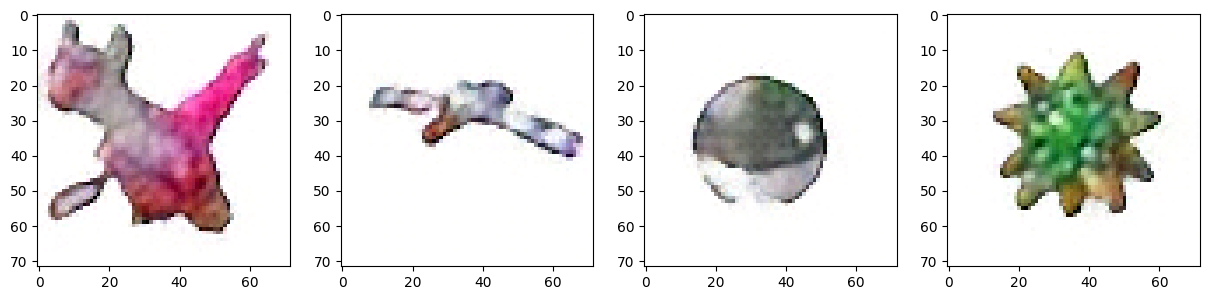

 68%|██████▊   | 33999/50000 [11:27<05:46, 46.13it/s]

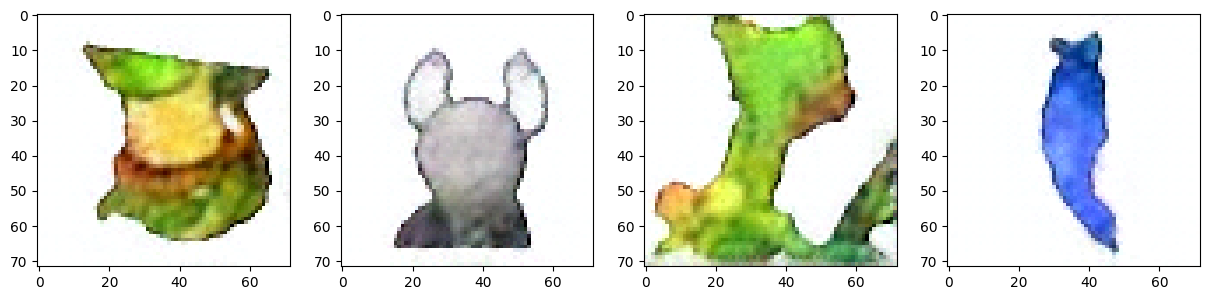

 70%|███████   | 35000/50000 [11:47<05:26, 45.92it/s]

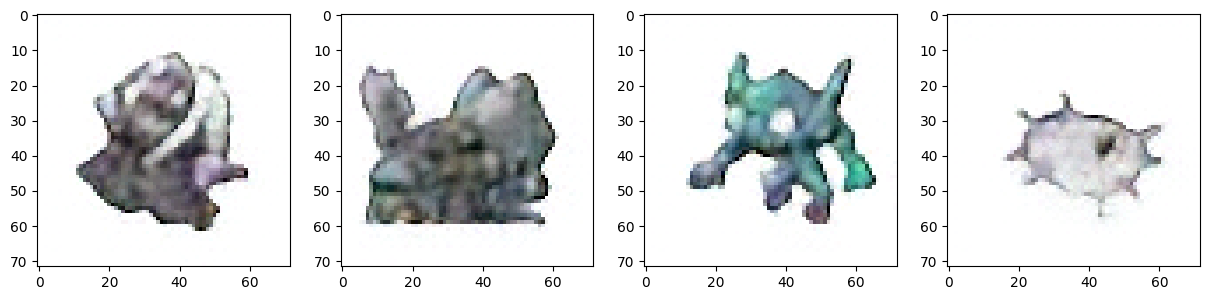

 72%|███████▏  | 35994/50000 [12:07<04:24, 52.89it/s]

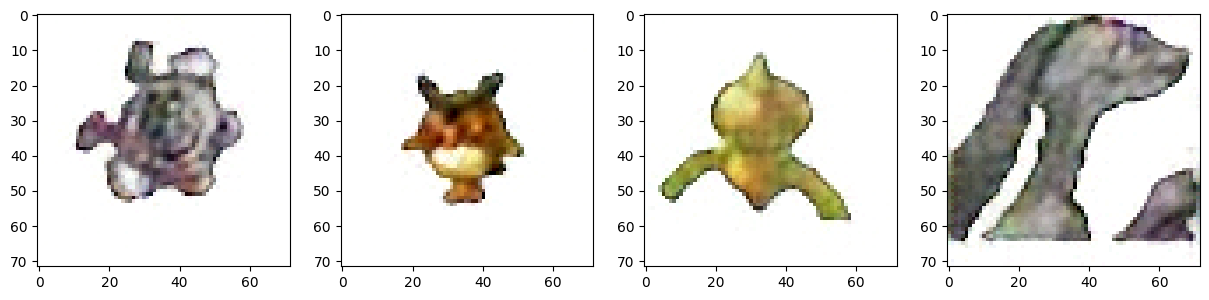

 74%|███████▍  | 36995/50000 [12:27<04:24, 49.22it/s]

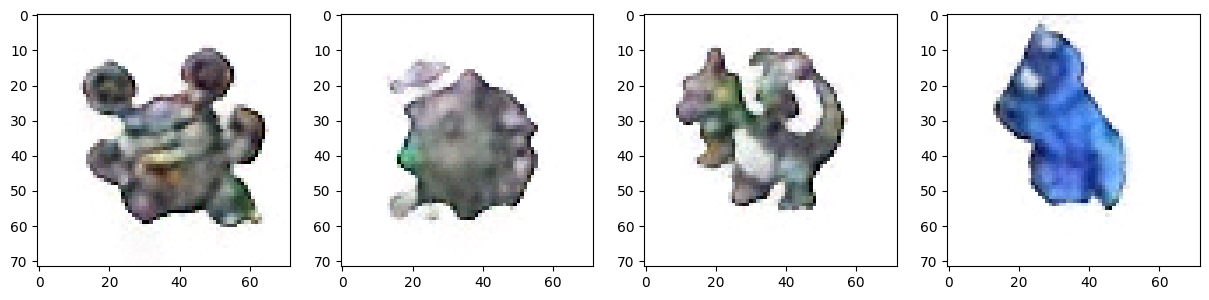

 76%|███████▌  | 37996/50000 [12:48<03:43, 53.70it/s]

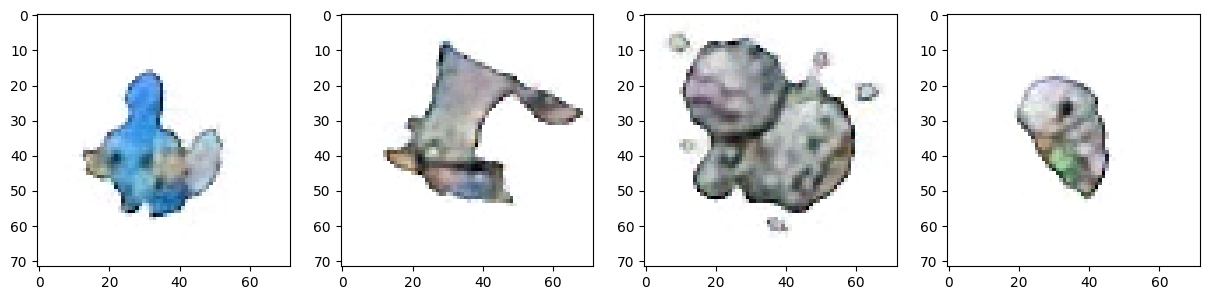

 78%|███████▊  | 38997/50000 [13:08<03:42, 49.52it/s]

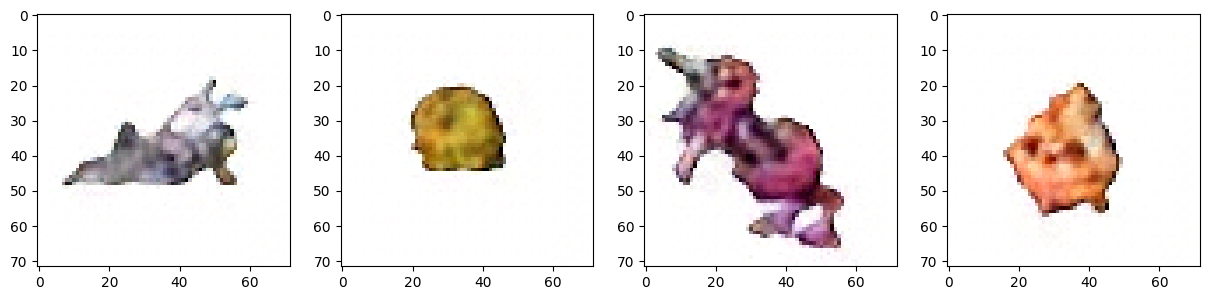

 80%|███████▉  | 39998/50000 [13:29<03:23, 49.16it/s]

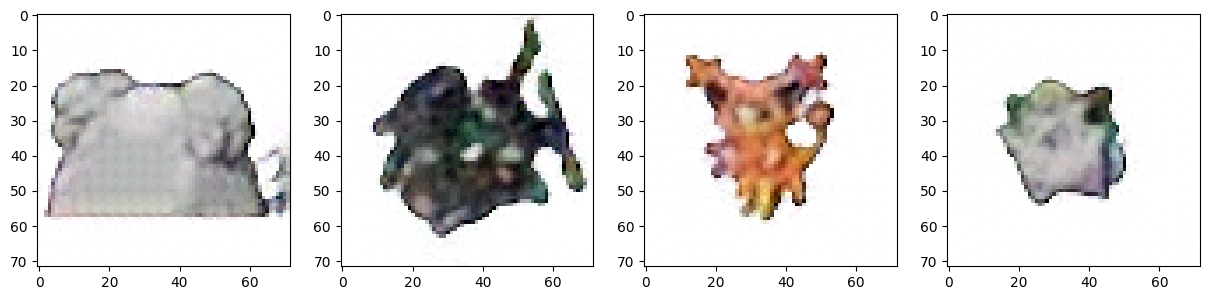

 82%|████████▏ | 40999/50000 [13:49<02:55, 51.32it/s]

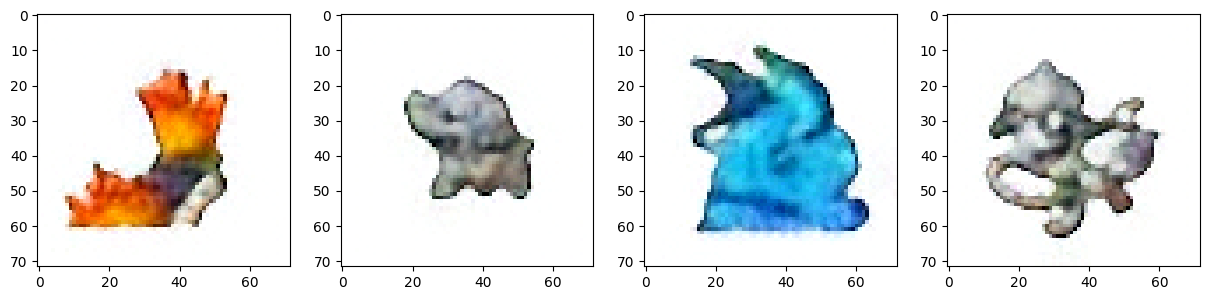

 84%|████████▍ | 42000/50000 [14:09<02:42, 49.33it/s]

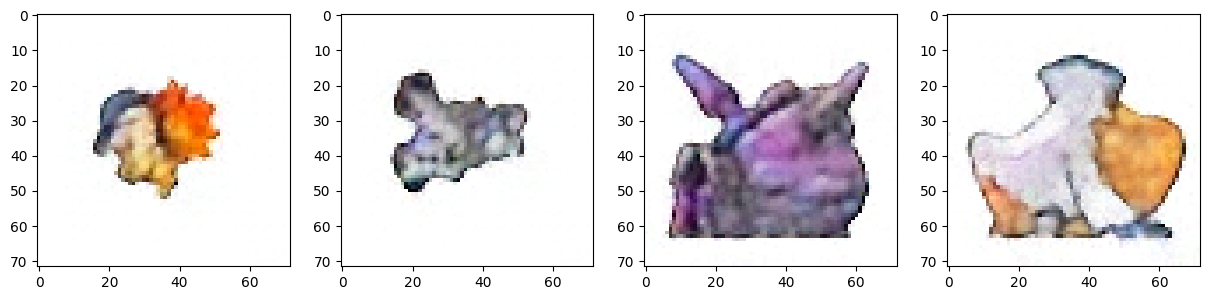

 86%|████████▌ | 42994/50000 [14:28<02:00, 58.35it/s]

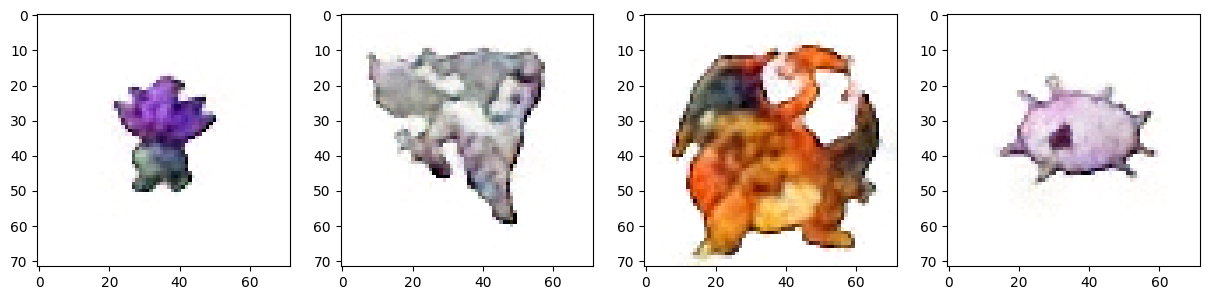

 88%|████████▊ | 43995/50000 [14:48<01:54, 52.37it/s]

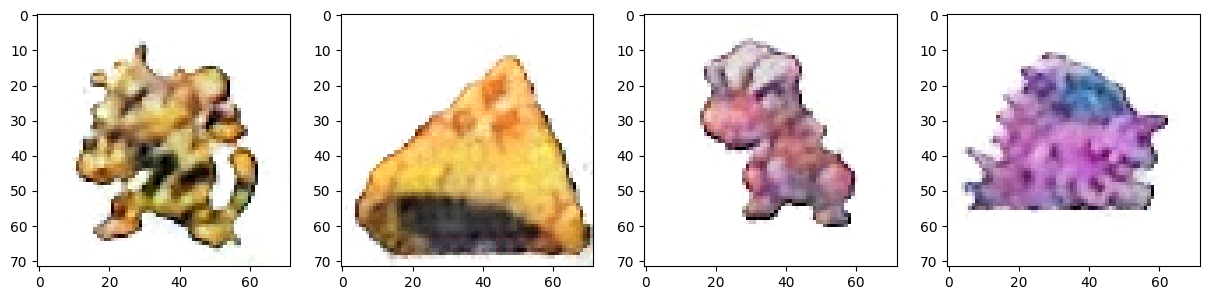

 90%|████████▉ | 44996/50000 [15:08<01:36, 51.78it/s]

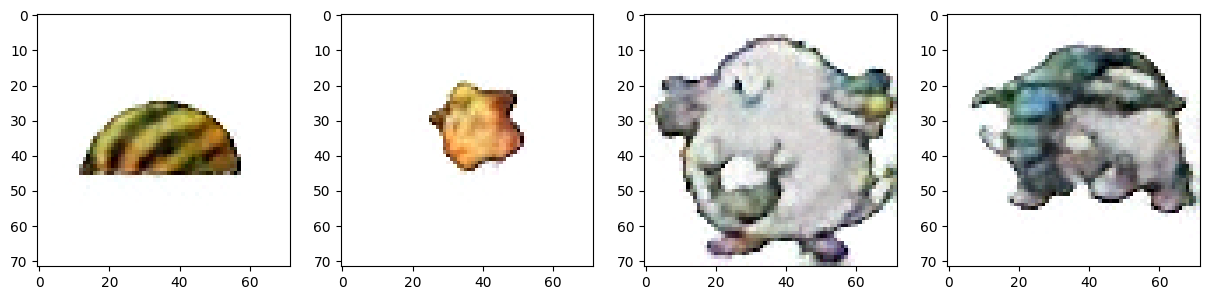

 92%|█████████▏| 45997/50000 [15:27<01:18, 50.81it/s]

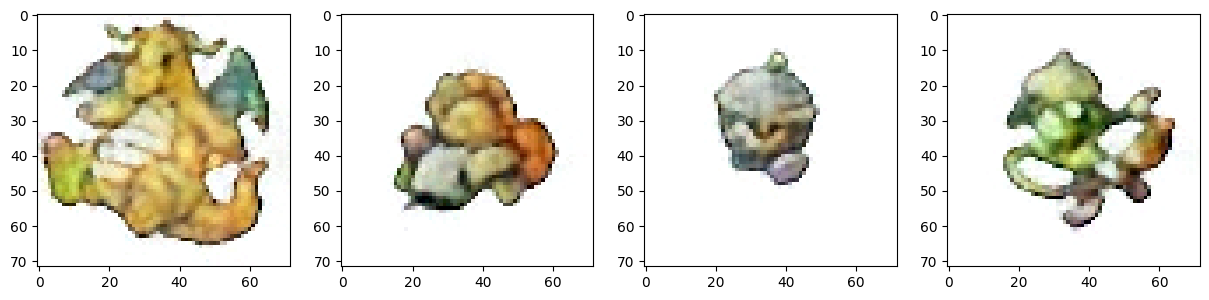

 94%|█████████▍| 46998/50000 [15:47<00:56, 53.03it/s]

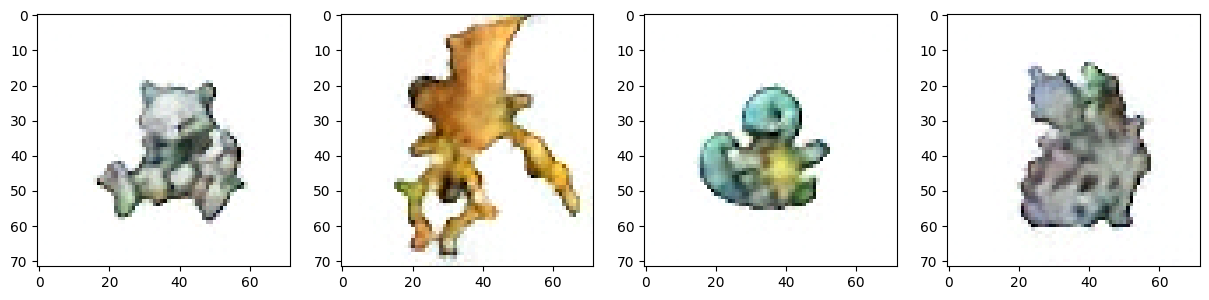

 96%|█████████▌| 47999/50000 [16:07<00:38, 52.20it/s]

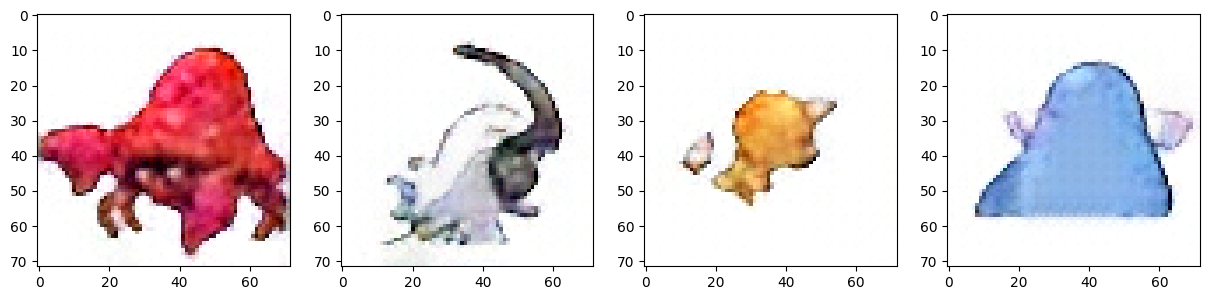

 98%|█████████▊| 49000/50000 [16:26<00:21, 47.55it/s]

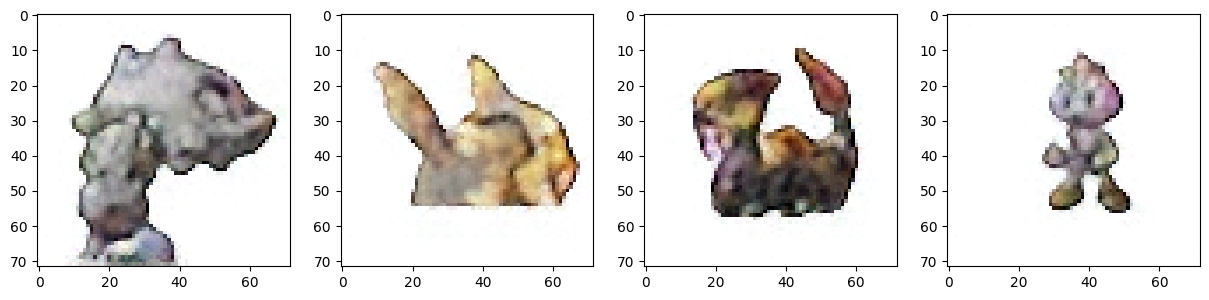

100%|██████████| 50000/50000 [16:45<00:00, 49.71it/s]


In [4]:
model = VQVAE(h_dim=128, res_h_dim=32, n_res_layers=2, n_embeddings=512, embedding_dim=64, beta=.25).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4, amsgrad=True)
mse_loss = nn.MSELoss()

results = {
    'n_updates': 0,
    'recon_errors': [],
    'loss_vals': [],
    'perplexities': [],
}

def train():

    for i in tqdm(range(50000), miniters=7):

        bs = 32
        source = torch.randint(0, 5, (bs,))
        batch = torch.randperm(385)[:bs]
        x0 = pimages[source, batch]
        x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)

        optimizer.zero_grad()

        embedding_loss, x_hat, perplexity = model(x0)
        recon_loss = mse_loss(x_hat, x0) + 2.0 * ssim_loss(x_hat, x0).mean()
        loss = recon_loss.mean() + embedding_loss

        loss.backward()
        optimizer.step()

        results["recon_errors"].append(recon_loss.cpu().detach().numpy())
        results["perplexities"].append(perplexity.cpu().detach().numpy())
        results["loss_vals"].append(loss.cpu().detach().numpy())
        results["n_updates"] = i

        N = 1000
        if i % N == 0:
            fig, axes = plt.subplots(1, 4, figsize=(15, 15))
            plot_image(x_hat[0], axes[0])
            plot_image(x_hat[1], axes[1])
            plot_image(x_hat[2], axes[2])
            plot_image(x_hat[3], axes[3])
            plt.show()
            #print('Update #', i, 'Recon Error:',
            #      np.mean(results["recon_errors"][-N:]),
            #      'Loss', np.mean(results["loss_vals"][-N:]),
            #      'Perplexity:', np.mean(results["perplexities"][-N:]))
        
        
            
model.train()
train()
